In [1]:
import torchvision
import torch
from torch.autograd import Variable
from train import DatasetFromHdf5, grayloader, Noise, l2loss
import torchvision.transforms
from torch.utils.data import DataLoader
from skimage import io
import numpy as np
import time
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
model = torch.load('/Users/luwang/Desktop/projects/personal/psf-estimation/psf-estimation/data/PSF_Estimation 2/models/newmodel.pt')
# model = torch.load('/Users/luwang/Desktop/projects/personal/psf-estimation/psf-estimation/data/PSF_Estimation 2/models/model_128_n_1_s_0_p_0_b_5_1dzernike_102_resnet34_ep16_trainerr0.003_testerr0.051.pt')
model.avgpool = torch.nn.AvgPool2d(kernel_size=7, stride=1, padding=0)

# functions

In [3]:
def preprocess_img(img_path):
    img = io.imread(img_path, as_gray=True)
    if img.dtype != np.uint16:
        if img.dtype == np.float64:
            img = (img * 65535).astype(np.int32)
            img = np.clip(img, 0, 65535)
        else:
            print('invalid image input')
            return
    # convert to int32 because uint16 cannot be converted to Tensor
    elif img.dtype == np.uint16: #     [0,65535]
        img = img.astype(np.int32) # [-2147483648, 2147483648]
    return img

In [4]:
def get_weightmap_and_patches(img, patch_size=128, step=64, verbose=False):
    ### expects 2D img array, with dtype uint16 [0,65535] intensity values (common for scientific imaging)
    
    # validate inputs
    assert(step <= patch_size)
    if verbose:
        print(f'Generating weight map and patches using patch of size ({patch_size},{patch_size}) and step of {step}.')
    
    n_channels = 1 # might not be necessary to specify??
    n_classes = 4
    
    # resize image to integer multiple of the patch size (TODO: change to center_crop())
    _img = img[0:img.shape[0]//patch_size * patch_size, 0:img.shape[1]//patch_size * patch_size]
    if verbose:
        print(f'Recropped image... Original shape: {img.shape}. New shape: {_img.shape}')
    
    # final psf_map is divided by the weight map to normalize areas between overlapping patches
    weight_map = np.zeros((_img.shape[0], _img.shape[1], n_classes))
    patches = []
    
    # slide moving window through the image and save patches
    ix, iy = patch_size, patch_size
    while iy <= _img.shape[0]: # < or <=??
        while ix <= _img.shape[1]:
            patch = _img[iy-patch_size:iy, ix-patch_size:ix]
            patches.append(patch)
            weight_map[iy-patch_size:iy, ix-patch_size:ix] += 1.0
            ix += step
        ix = patch_size
        iy += step
    
    # reshape patches array to (n_patches, n_channels, patch_size, patch_size)
    patches = np.array(patches)
    patches = np.reshape(patches, (len(patches), n_channels, patch_size, patch_size))
    
    if verbose:
        print(f'Weight map and patches generated... Weight map shape: {weight_map.shape}. Patches tensor shape: {patches.shape}')
    
    return weight_map, torch.FloatTensor(patches), _img

In [26]:
def predict_on_patches(model, patches, max_batch_size=16, verbose=False):
    remaining_patches = len(patches)
    a_predictions = np.zeros((len(patches), 4))
    
    # for each batch of patches, predict a0,a1,a2,a3 values
    if verbose:
        total_patches = remaining_patches
        print(f'Generating predictions for {total_patches} patches in batches of {max_batch_size}.')
        start = time.time()
    p = 0 # index of first patch in next batch
    while remaining_patches > 0:
        if verbose:
            progress = (total_patches - remaining_patches) / total_patches * 100
            print(f"\rProgress: [{'=' * int(progress / 2):<50}] {total_patches-remaining_patches}/{total_patches}", end='', flush=True)

        batch_size = min(max_batch_size, remaining_patches)
        output = model(Variable(patches.narrow(0, p, batch_size), requires_grad=False)) #.cuda()
        output = (output * 100.).round() / 100. # round off results
        output[:,0] = output[:,0].round() # round a_0 to 0 or 1
        a_predictions[p:p+batch_size] = output.data.cpu().numpy()
        
        p += batch_size
        remaining_patches -= batch_size
        
    if verbose:
        print(f"\rProgress: [{'=' * int(progress / 2):<50}] {total_patches}/{total_patches}", end='', flush=True)
        end = time.time()
        print(f'\nTotal prediction time: {end-start:.2f} seconds')
        
    return a_predictions

In [6]:
def compose_psf_map(a_predictions, weight_map, patch_size, step, verbose=False):
    img_height, img_width = weight_map.shape[0], weight_map.shape[1]
    psf_map = np.zeros((weight_map.shape[0], weight_map.shape[1], a_predictions.shape[1]))
    if verbose:
        print(f'Composing PSF map of shape {psf_map.shape} from {len(a_predictions)} patches.')

    # slide through the image shape and sum the overlapping predictions
    ix, iy = patch_size, patch_size
    p = 0
    while iy <= img_height:
        while ix <= img_width:
            psf_map[iy-patch_size:iy, ix-patch_size:ix] += a_predictions[p, :]
            ix += step
            p += 1
        ix = patch_size
        iy += step
    # average out prediction sums using the weight map
    psf_map = psf_map / weight_map
    # psf_map[:,:,0] = np.round(psf_map[:,:,0])
    
    return psf_map

In [25]:
def process_one_image(img, model, patch_size=128, step=64, max_batch_size=16, verbose=False, debug=False):
    weight_map, patches, _img = get_weightmap_and_patches(img, patch_size, step, verbose=verbose)
    a_predictions = predict_on_patches(model, patches, max_batch_size, verbose=verbose)
    psf_map = compose_psf_map(a_predictions, weight_map, patch_size, step, verbose=verbose)
    if debug:
        return _img, weight_map, patches, a_predictions, psf_map
    return psf_map

In [8]:
def show_results(img_path, psf_map):
    fig, axs = plt.subplots(2, 2)

    # plot data on each subplot, calculate vmin/vmax for colorbars
    cmap = 'RdBu'
    axs[0, 0].imshow(io.imread(img_path, as_gray=True), cmap='viridis')
    _lim1 = max(psf_map[:,:,1].min(), psf_map[:,:,1].max())
    axs[0, 1].imshow(psf_map[:,:,1], cmap=cmap, vmin=-_lim1, vmax=_lim1)
    _lim2 = max(psf_map[:,:,3].min(), psf_map[:,:,3].max())
    axs[1, 0].imshow(psf_map[:,:,3], cmap=cmap, vmin=-_lim2, vmax=_lim2)
    feat13 = psf_map[:,:,1] * (psf_map[:,:,3]-0.0)
    _lim3 = max(feat13.min(), feat13.max())
    axs[1, 1].imshow(feat13, cmap=cmap, vmin=-_lim3, vmax=_lim3) # 0.0 or -0.5??

    # add titles and colorbars
    axs[0, 0].set_title('original')
    axs[0, 1].set_title('defocus (a1)')
    axs[1, 0].set_title('astig axis (a3)')
    axs[1, 1].set_title('depth estimate (a1 * a3)')
    fig.colorbar(axs[0, 0].get_images()[0], ax=axs[0, 0], fraction=0.04, pad=0.02)
    fig.colorbar(axs[0, 1].get_images()[0], ax=axs[0, 1], fraction=0.04, pad=0.02)
    fig.colorbar(axs[1, 0].get_images()[0], ax=axs[1, 0], fraction=0.04, pad=0.02)
    fig.colorbar(axs[1, 1].get_images()[0], ax=axs[1, 1], fraction=0.04, pad=0.02)

    plt.tight_layout()
    plt.show()

# test 1: microscope slide

In [7]:
img_path = '/Users/luwang/Desktop/projects/personal/psf-estimation/psf-estimation/data/PSF_Estimation/astigmatism/tilted/10/10degres_proche_2/MMStack_Pos0.ome.tif'
# img_path = '/Users/luwang/Desktop/projects/personal/psf-estimation/psf-estimation/data/PSF_Estimation/astigmatism/tilted/10/10degres_proche_3/MMStack_Pos0.ome.tif'
img = preprocess_img(img_path) # img should be a 2D image with intensity values [0,65535] (uint16)
psf_map = process_one_image(img, model, patch_size=128, step=64, max_batch_size=16, verbose=True)

Generating weight map and patches using patch of size (128,128) and step of 64.
Recropped image... Original shape: (2046, 2046). New shape: (1920, 1920)
Weight map and patches generated... Weight map shape: (1920, 1920, 4). Patches tensor shape: (841, 1, 128, 128)
Generating predictions for 841 patches in batches of 16.
Progress: [================================================= ] 841/841
Total prediction time: 62.66 seconds
Composing PSF map of shape (1920, 1920, 4) from 841 patches.


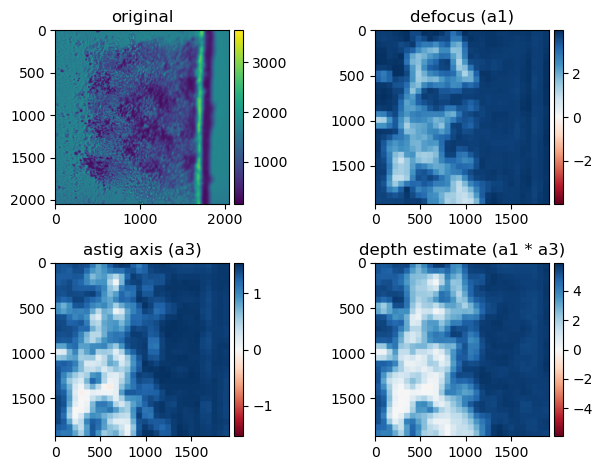

In [45]:
show_results(img_path, psf_map)

# test 2: arbitrary image

In [54]:
test_pa = 'test2.png'
test_img = preprocess_img(test_pa) # img should be a 2D image with intensity values [0,65535] (uint16)
_im, we, pa, ap, psf = process_one_image(test_img, model, patch_size=128, step=32, max_batch_size=16, debug=True, verbose=True)

Generating weight map and patches using patch of size (128,128) and step of 32.
Recropped image... Original shape: (746, 1004). New shape: (640, 896)
Weight map and patches generated... Weight map shape: (640, 896, 4). Patches tensor shape: (425, 1, 128, 128)
Generating predictions for 425 patches in batches of 16.
Progress: [================================================  ] 425/425
Total prediction time: 42.22 seconds
Composing PSF map of shape (640, 896, 4) from 425 patches.


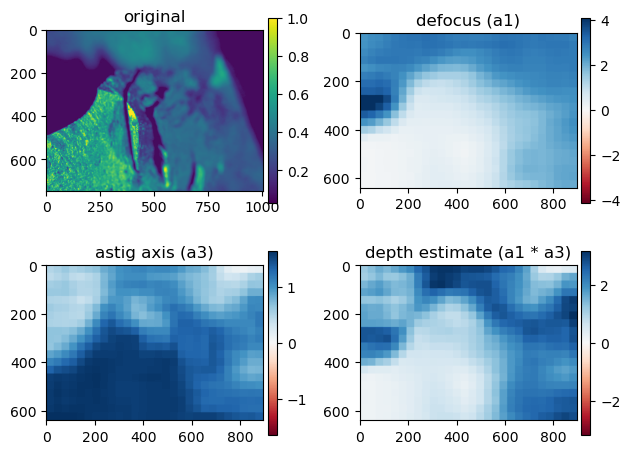

In [56]:
show_results(test_pa, psf)

# calibration

In [52]:
syn_image_stack = np.load('syn_image_stack.npy')
z_list = np.load('z_list.npy')
print(syn_image_stack.shape)

(51, 2046, 2046)


In [53]:
def calculate_roi_size(n_patches, patch_size=128, step=64):
    size = patch_size + (patch_size - step) * (n_patches - 1)
    return size

In [54]:
def calibrate(img_stack, verbose=False):
    roi_x, roi_y = 384, 384
    size = calculate_roi_size(n_patches=5)
    
    psf_stack = []
    i = 0
    for img in img_stack:
        if verbose:
            print(i)
        roi = img[roi_y:roi_y+size, roi_x:roi_x+size]
        roi_psf = process_one_image(roi, model)
        psf_stack.append(roi_psf)
        i += 1
    # return:
    #   estimated Moffat distribution
    #   FWHM
    return np.array(psf_stack)

In [ ]:
calibration_stack = calibrate(syn_image_stack * 65535.0, verbose=True)

In [62]:
avg_a1_list = []
for c in calibration_stack:
    a1_preds = c[:,:,1]
    avg_a1_list.append(np.mean(a1_preds))
avg_a1_list = np.array(avg_a1_list)

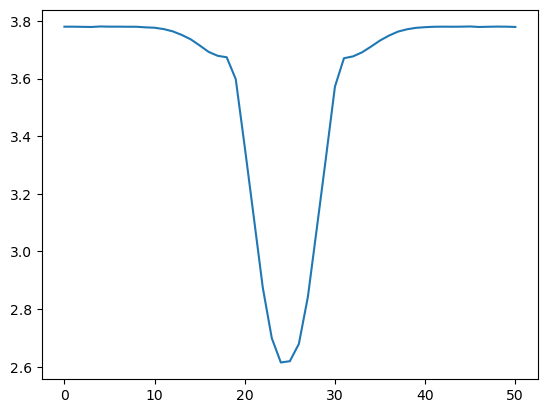

In [63]:
plt.plot(avg_a1_list)

# generate synthetically blurred image stack

In [ ]:
def generate_syn_img_stack(img, n, zmin, zmax, zfocus, noise_sigma, input_noise, width_coeff):
    

In [ ]:
def blur_image_stack(image, num_z, min_z_calib = None, max_z_calib = None, z_focus=0, noise_sigma=0.0, input_noise = 0.0, width_coeff = 1.0):
    im_size = image.shape[0]
    #kernels = np.zeros((im_size, num_z, num_z))
    log.info('Generating a blurred stack from {} to {} with {} images and centered at z={}.'.format(min_z_calib, max_z_calib, num_z, z_focus))
    
    kernels = []
    z_coeff = 1.7*width_coeff # scaling coefficient for translating z-index to a distance
    noise = np.random.normal(0, noise_sigma, num_z)
    kernel_size = im_size // 2 + 1
    if kernel_size % 2 == 0: # if even kernel size, make odd
        kernel_size += 1
    if num_z == 1: # if only 1 sample:
        dist = abs(float(max_z_calib-z_focus) * z_coeff)
        dist += noise[0] # add noise to the distance (this simulates additional gaussian blur)
        kernels.append(gaussian_kernel(kernel_size, fwhmx=dist, fwhmy=dist) * (im_size ** 2))
    else:
        z_list = np.linspace (min_z_calib-z_focus+1, max_z_calib-z_focus, num_z).tolist()
        for z_idx, z in enumerate(z_list):
            if not isinstance(z, float):
                z = z[0]
            dist = np.abs(z*z_coeff)
            dist += noise[z_idx]
            kernels.append(gaussian_kernel(kernel_size, fwhmx=dist, fwhmy=dist) * (im_size ** 2))
    #plot_images(kernels)

    all_images = []
    i = 0
    uni = np.random.uniform(input_noise // 2, input_noise * 2, len(kernels))
    for kernel in kernels:
        c = convolve(image, kernel, padding='reflect')
        c = noisy(c, 'gauss', uni[i])
        c = c.clip(0.01,0.95)
        i +=1

        all_images.append(center_crop_pixel(c,image.shape[0]))
    #plot_images(all_images)
    #plt.show()
    return np.asarray(all_images), np.linspace(min_z_calib, max_z_calib, num_z)


In [65]:
transform = torchvision.transforms.Compose([Noise(probability=0.0, noise_type=None)])
transform2 = torchvision.transforms.Compose([Noise(probability=0.25, noise_type='poigauss')])

test_dataset = DatasetFromHdf5('/Users/luwang/Desktop/projects/personal/psf-estimation/psf-estimation/data/PSF_Estimation 3/synthetic_images/psf_128_n_0_s_0_p_10_b_2_noise_0_2dzernike_test/data.h5',
                              loader=grayloader,
                              transform=transform)

test_dataset2 = DatasetFromHdf5('/Users/luwang/Desktop/projects/personal/psf-estimation/psf-estimation/data/PSF_Estimation 3/synthetic_images/psf_128_n_0_s_0_p_10_b_2_noise_0_2dzernike_test/data.h5',
                              loader=grayloader,
                              transform=transform2)

/Users/luwang/Desktop/projects/personal/psf-estimation/psf-estimation/data/PSF_Estimation 3/synthetic_images/psf_128_n_0_s_0_p_10_b_2_noise_0_2dzernike_test/data.h5
/Users/luwang/Desktop/projects/personal/psf-estimation/psf-estimation/data/PSF_Estimation 3/synthetic_images/psf_128_n_0_s_0_p_10_b_2_noise_0_2dzernike_test/data.h5


/Users/luwang/opt/anaconda3/envs/semiblind-deconvolution-env/lib/python3.11/site-packages/skimage/io/_plugins/matplotlib_plugin.py:149: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


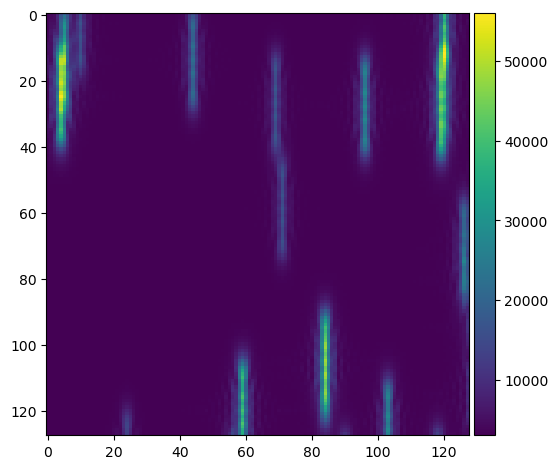

In [ ]:
io.imshow(test_dataset[0][0].permute(1, 2, 0).cpu().numpy())

/Users/luwang/opt/anaconda3/envs/semiblind-deconvolution-env/lib/python3.11/site-packages/skimage/io/_plugins/matplotlib_plugin.py:149: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


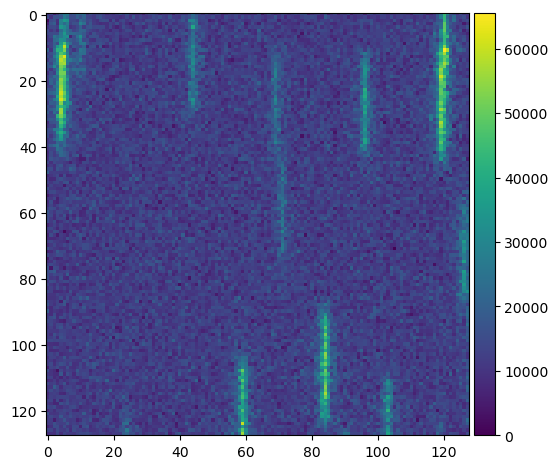

In [ ]:
io.imshow(test_dataset2[0][0].permute(1, 2, 0).cpu().numpy())

In [ ]:
test_loader = DataLoader(dataset=test_dataset, 
                                  batch_size=4, 
                                  shuffle=True,
                                  num_workers=0)

In [ ]:
max_image = 3
model.eval()

i = 0
for image, label in test_loader:
    if i > max_image:
        break
    # output = model(Variable(image, requires_grad=False).cuda())
    vari = Variable(image, requires_grad=False).cpu()
    output = model(vari)
    print(output)
    i += 1

tensor([[ 0.0042, -0.1061,  1.0125, -0.0036],
        [ 0.0068, -0.0205,  0.8613,  1.5511],
        [-0.0934,  2.5225,  0.4113,  1.4825],
        [-0.0090,  0.1201,  1.0606, -0.0479]], grad_fn=<AddmmBackward0>)
tensor([[ 0.0099, -0.0442,  0.4633,  1.5626],
        [ 0.0055,  0.3831,  2.6406, -0.0126],
        [ 0.0051,  0.2421,  0.6665,  1.5179],
        [-0.0934,  2.5225,  0.4113,  1.4825]], grad_fn=<AddmmBackward0>)
tensor([[-0.0030, -0.0912,  1.2239,  0.0116],
        [ 0.0168, -0.0576,  2.5139,  1.5843],
        [ 0.0099,  0.9294,  0.2068,  1.1116],
        [-0.0076, -0.0438,  2.5778, -0.0055]], grad_fn=<AddmmBackward0>)
tensor([[ 0.0142, -0.0071,  0.3030,  1.5845],
        [ 0.5159, -0.0692,  0.9095,  1.6089],
        [-0.0193, -0.1755,  0.8415,  0.0264],
        [ 0.0527, -0.0162,  0.7735,  0.0111]], grad_fn=<AddmmBackward0>)


In [ ]:
output.shape

torch.Size([4, 4])

In [ ]:
i = 0
for batch, labels in test_loader:
    if i > 0:
        break
    inputs = Variable(batch, requires_grad=False).cpu()
    outputs = model(inputs)
    print(labels)
    print(outputs)
    print(l2loss(outputs, Variable(labels).float()).cpu().data.numpy())
    i += 1

tensor([[1.0000e+00, 1.0000e+03, 1.0000e+03, 1.0000e+03],
        [0.0000e+00, 2.0482e-01, 9.2124e-01, 1.5708e+00],
        [0.0000e+00, 4.8440e-02, 1.0791e+00, 0.0000e+00],
        [0.0000e+00, 5.8211e-01, 1.8070e+00, 0.0000e+00]])
tensor([[-0.0934,  2.5225,  0.4113,  1.4825],
        [ 0.3917, -0.1068,  0.9932,  1.6009],
        [ 0.0135, -0.0661,  1.1361,  0.0156],
        [-0.0072,  0.2515,  1.7626,  0.0251]], grad_fn=<AddmmBackward0>)
0.36136267
